# Initialization

## Imports

In [69]:
import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
from cbrain.climate_invariant import *

import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
# from climate_invariant import *
from tensorflow.keras import layers
import datetime
import yaml

## Global Variables

In [70]:
# Load coordinates (just pick any file from the climate model run)

# GP path below
path_0K = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/fluxbypass_aqua/'
coor = xr.open_dataset(path_0K+"AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-09-02-00000.nc")

lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [71]:
path_folRG = '/DFS-L/DATA/pritchard/liranp/'
path_RG0K = path_folRG + 'SST_0001Kp_Neuralnet_SPCAM_all_216/atm/hist/SST_0001Kp_Neuralnet_SPCAM_all_216.cam.h1.2013-'
path_RG0K = path_RG0K + '05-05-*.nc'

coor_RG = xr.open_mfdataset(path_RG0K,decode_cf=False)
latRG = coor_RG.lat; lonRG = coor_RG.lon; levRG = coor_RG.lev;
coor_RG.close();

In [72]:
# GP path below
TRAINDIR = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path = '/export/nfs0home/tbeucler/CBRAIN-CAM/cbrain/'
path_nnconfig = '/export/nfs0home/tbeucler/CBRAIN-CAM/nn_config/'

# Load hyam and hybm to calculate pressure field in SPCAM
path_hyam = 'hyam_hybm.pkl'
hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)

# Scale dictionary to convert the loss to W/m2
scale_dict = load_pickle(path_nnconfig+'scale_dicts/009_Wm2_scaling.pkl')

# Table 1: Simulation characteristics

In [73]:
coor_RG['lev'][10]

<xarray.DataArray 'lev' ()>
array(142.994039)
Coordinates:
    lev      float64 143.0
Attributes:
    long_name:      hybrid level at midpoints (1000*(A+B))
    units:          level
    positive:       down
    standard_name:  atmosphere_hybrid_sigma_pressure_coordinate
    formula_terms:  a: hyam b: hybm p0: P0 ps: PS

# Table 2: PDF similarity metrics (SJ and Hellinger)

Inspired from [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/044_Climate_invariant_analysis_output_scaling.ipynb]

## Utilities

In [74]:
def Hellinger(x,f,g):
    return np.sqrt(np.trapz(y=0.5*(np.sqrt(f)-np.sqrt(g))**2,x=x))

In [75]:
def KL(x,f,g,eps=1e-4):
    f = np.maximum(eps,f)
    g = np.maximum(eps,g)
    return np.trapz(y=f*np.log(f/g),x=x)

In [76]:
def JS(x,f,g,eps=1e-4):
    return np.sqrt(0.5*(KL(x,f,g,eps)+KL(x,g,f,eps)))

In [77]:
def maxmin_norm(xf,xg,f,g):
    
    fg_xmax = np.maximum(np.max(xf),np.max(xg))
    fg_xmin = np.minimum(np.min(xf),np.min(xg))
    xf_norm = (xf-fg_xmin)/(fg_xmax-fg_xmin)
    xg_norm = (xg-fg_xmin)/(fg_xmax-fg_xmin)
    
    fg_max = np.maximum(np.max(f),np.max(g))
    fg_min = np.minimum(np.min(f),np.min(g))
    f_norm = (f-fg_min)/(fg_max-fg_min)
    g_norm = (g-fg_min)/(fg_max-fg_min)
    
    return xf_norm,xg_norm,f_norm,g_norm

In [78]:
# From https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-np
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- np ndarrays with the same shape.
    """
    if np.sum(weights)>0:
        average = np.average(values, weights=weights)
        variance = np.average((values-average)**2, weights=weights)
    else: average = np.nan; variance = np.nan
    return (average, np.sqrt(variance))

# Make function to calculate conditional mean and std
# We condition field_y on field_x
def conditional_avg_and_std(bin_edges,field_x,field_y):
    # Initialization
    Nbin = np.size(bin_edges)
    Ym = np.zeros((Nbin-1,1))
    Ystd = np.copy(Ym)

    for ibin,edge in enumerate(bin_edges):
        print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
        if ibin>0:
            w = (field_x>=edge_left)*(field_x<edge)
            Ym[ibin-1],Ystd[ibin-1] = weighted_avg_and_std(field_y,w)

        edge_left = edge
    
    return Ym,Ystd

In [79]:
def plot_verthist(S):
    fig, ax = plt.subplots(20,1,figsize=(15,25))

    iav = 0
    JS_mean = 0
    Hel_mean = 0

    for icount,ilev in enumerate(np.arange(10,30)):
        TITLE = 'Hel/JS='
        for idata,data in enumerate(['m4K','ref','p4K']):
            ax[icount].plot(edg2bin(S[ilev][data][1]),S[ilev][data][0],color=COL[idata])
            ax[icount].set_ylabel(str(ilev))

            f_cold = S[ilev]['m4K'][0]; x_cold = edg2bin(S[ilev]['m4K'][1])
            f_data = S[ilev][data][0]; x_data = edg2bin(S[ilev][data][1])

            xf_norm,xg_norm,f_norm,g_norm = maxmin_norm(x_cold,x_data,f_cold,f_data)
            x = np.linspace(0,1,1000)

            f = np.interp(x=x,xp=xf_norm,fp=f_norm)
            g = np.interp(x=x,xp=xg_norm,fp=g_norm)

            H = Hellinger(x,f,g)
            JS0 = JS(x,f,g,eps=1e-4)

            iav += 1
            JS_mean += JS0
            Hel_mean += H

            TITLE += '('+data+') '+str(H)[:5]+'/'+str(JS0)[:5]+' '
        ax[icount].set_title(TITLE)
    fig.tight_layout()
    print('Mean JS is ',str(100*JS_mean/iav),'% and mean Hellinger is ',str(100*Hel_mean/iav),'%')
    
    return JS_mean/iav,Hel_mean/iav

In [80]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

## Load PDFs

In [114]:
path_array = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
     '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
     '2021_06_03_RG_TRAIN_shuffle.nc',
     '2021_04_18_RG_TRAIN_P4K_shuffle.nc',
    '1','2','3' # dummy paths for HH simulations
]

Load Q

In [88]:
pathPKL = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/PKL_DATA/'

In [89]:
save_name = '2021_06_07_AQUA_RG_Qhist'

In [90]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

Q_data = pickle.load(hf)
hf.close()

Load T

In [91]:
save_name = '2021_06_07_AQUA_RG_Thist'

In [92]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

T_data = pickle.load(hf)
hf.close()

Load T at 200hPa

In [93]:
save_name = '2021_08_18_AQUA_RG_Thist_ilev'+str(12)

In [94]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

T200_data = pickle.load(hf)
hf.close()

Load T at 150hPa

In [95]:
save_name = '2021_08_18_AQUA_RG_Thist_ilev'+str(10)

In [96]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

T150_data = pickle.load(hf)
hf.close()

Load B

In [97]:
path = '2021_06_21_distributions_BMSE'

In [98]:
hf = open(pathPKL+'/'+path+'.pkl','rb')

B_data = pickle.load(hf)
hf.close()

Load LHF

In [99]:
save_name = '2021_06_07_AQUA_RG_LHFhist'

In [100]:
hf = open(pathPKL+'/'+save_name+'.pkl','rb')

LHF_data = pickle.load(hf)
hf.close()

Load hypohydrostatic histograms

In [101]:
fol_Janni = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/Janni_data/'

In [102]:
Q_data_HH = pickle.load(open(fol_Janni+'q_hists.pkl','rb'))

In [103]:
HHdic = {}
HHdic['QV'] = 'qv';
HHdic['RH'] = 'RH';
HHdic['QfromQsat'] = 'q_deficit'

In [104]:
T_data_HH = pickle.load(open(fol_Janni+'T_hists.pkl','rb'))

In [105]:
T_data_HH['edgQ'].keys()

dict_keys(['Tin', 'BMSE', 'T_mTNS'])

In [106]:
HHdic['T'] = 'Tin'
HHdic['BMSE'] = 'BMSE'
HHdic['TfromNS'] = 'T_mTNS'

In [107]:
T150_data_HH = pickle.load(open(fol_Janni+'T_hists_148hPa.pkl','rb'))

In [108]:
T150_data_HH['edgQ'].keys()

dict_keys(['Tin', 'BMSE', 'T_mTNS'])

Group all variables into the same structure

In [27]:
hisQ = {}
edgQ = {}

for ikey,key in enumerate(['QV','RH','QfromQsat']):
    hisQ[key] = {}
    edgQ[key] = {}
    for ipath,path in enumerate(path_array):
        hisQ[key][path] = {}
        edgQ[key][path] = {}

In [28]:
hisT = {}
edgT = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT[key] = {}
    edgT[key] = {}
    for ipath,path in enumerate(path_array):
        hisT[key][path] = {}
        edgT[key][path] = {}

In [29]:
hisT150 = {}
edgT150 = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT150[key] = {}
    edgT150[key] = {}
    for ipath,path in enumerate(path_array):
        hisT150[key][path] = {}
        edgT150[key][path] = {}

In [30]:
hisT200 = {}
edgT200 = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT200[key] = {}
    edgT200[key] = {}
    for ipath,path in enumerate(path_array):
        hisT200[key][path] = {}
        edgT200[key][path] = {}

In [31]:
hisLHF = {}
edgLHF = {}

for ikey,key in enumerate(['LHF','LHF_nsQ','LHF_nsDELQ']):
    hisLHF[key] = {}
    edgLHF[key] = {}
    for ipath,path in enumerate(path_array):
        hisLHF[key][path] = {}
        edgLHF[key][path] = {}

In [32]:
hisQ = Q_data['hisQ']
edgQ = Q_data['edgQ']
# Convert specific humidities to g/kg
for ipath,path0 in enumerate(path_array):
    for ikey,key in enumerate(['QV','QfromQsat']):
        edgQ[key][path0] *= 1e3

hisT = T_data['hisT']
edgT = T_data['edgT']
# Load buoyancy from MSE
ilevB = 23
for ikey,key in enumerate(['BMSE']):
    hisT[key] = {}
    edgT[key] = {}
    for ipath,path in enumerate(path_array):
        hisT[key][path] = B_data['hisT'][ilevB][path]
        edgT[key][path] = B_data['edgT'][ilevB][path]

hisT200 = T200_data['hisT']
edgT200 = T200_data['edgT']
# Load buoyancy from MSE
ilevB = 12
for ikey,key in enumerate(['BMSE']):
    hisT200[key] = {}
    edgT200[key] = {}
    for ipath,path in enumerate(path_array):
        hisT200[key][path] = B_data['hisT'][ilevB][path]
        edgT200[key][path] = B_data['edgT'][ilevB][path]
        
hisT150 = T150_data['hisT']
edgT150 = T150_data['edgT']
# Load buoyancy from MSE
ilevB = 10
for ikey,key in enumerate(['BMSE']):
    hisT150[key] = {}
    edgT150[key] = {}
    for ipath,path in enumerate(path_array):
        hisT150[key][path] = B_data['hisT'][ilevB][path]
        edgT150[key][path] = B_data['edgT'][ilevB][path]

# Redefine Tarray to replace BCONS with BMSE for now
Tarray = ['T','BMSE','TfromNS']

hisLHF = LHF_data['hisLHF']
edgLHF = LHF_data['edgLHF']

Set histograms to zero for the (-4K) SAM simulations and load Janni values for the other sims

In [117]:
path_SAM = ['1','2','3']
for ipath,path0 in enumerate(path_SAM):
    
    for ikey,key in enumerate(['QV','RH','QfromQsat']):
        if ipath==2: 
            edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs']
            hisQ[key][path0] = 0*edg2bin(edgQ[key][path0])**0
        elif ipath==0: 
            hisQ[key][path0] = Q_data_HH['hisQ'][HHdic[key]]['qobs']
            if key=='RH': edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs']
            else: edgQ[key][path0] = 1e3*Q_data_HH['edgQ'][HHdic[key]]['qobs'] # Conversion in g/kg
        elif ipath==1: 
            hisQ[key][path0] = Q_data_HH['hisQ'][HHdic[key]]['qobs4K']
            if key=='RH': edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs4K']
            else: edgQ[key][path0] = 1e3*Q_data_HH['edgQ'][HHdic[key]]['qobs4K'] # Conversion in g/kg
    
    for ikey,key in enumerate(['T','BMSE','TfromNS']):
        if ipath==2: 
            edgT[key][path0] = T_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT[key][path0] = 0*edg2bin(edgT[key][path0])**0
            edgT150[key][path0] = T150_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT150[key][path0] = 0*edg2bin(edgT150[key][path0])**0
        elif ipath==0: 
            hisT[key][path0] = T_data_HH['hisQ'][HHdic[key]]['qobs']
            edgT[key][path0] = T_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT150[key][path0] = T150_data_HH['hisQ'][HHdic[key]]['qobs']
            edgT150[key][path0] = T150_data_HH['edgQ'][HHdic[key]]['qobs']
        elif ipath==1: 
            hisT[key][path0] = T_data_HH['hisQ'][HHdic[key]]['qobs4K']
            edgT[key][path0] = T_data_HH['edgQ'][HHdic[key]]['qobs4K']
            hisT150[key][path0] = T150_data_HH['hisQ'][HHdic[key]]['qobs4K']
            edgT150[key][path0] = T150_data_HH['edgQ'][HHdic[key]]['qobs4K']
            
    for ikey,key in enumerate(['LHF','LHF_nsQ','LHF_nsDELQ']):
            edgLHF[key][path0] = np.linspace(0,100,101)
            hisLHF[key][path0] = 0*edg2bin(edgLHF[key][path0])**0

## Calculate JS and Hellinger structures

In [110]:
JS0 = {}; Hel = {};

In [111]:
path_array

['2021_03_18_O3_TRAIN_M4K_shuffle.nc',
 '2021_01_24_O3_TRAIN_shuffle.nc',
 '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
 '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
 '2021_06_03_RG_TRAIN_shuffle.nc',
 '2021_04_18_RG_TRAIN_P4K_shuffle.nc']

### Test

In [38]:
fsave = {}; gsave = {}; 

In [118]:
for ivar,var in enumerate(['QV','T','T200','T150','LHF']):
    print('var=',var,end='\n')
    JS0[var] = {}; Hel[var] = {}; fsave[var] = {}; gsave[var] = {};
    if var=='QV': key_array = ['QV','RH','QfromQsat']; edg = edgQ; his = hisQ;
    elif var=='T': key_array = ['T','BMSE','TfromNS']; edg = edgT; his = hisT;
    elif var=='T200': edg = edgT200; his = hisT200;
    elif var=='T150': edg = edgT150; his = hisT150;
    elif var=='LHF': key_array = ['LHF','LHF_nsQ','LHF_nsDELQ']; edg = edgLHF; his  = hisLHF;
        
    for ikey,key in enumerate(key_array):
        print('key=',key,'                   ',end='\r')
        JS0[var][key] = {}; Hel[var][key] = {};
        fsave[var][key] = {}; gsave[var][key] = {};
        
        for ipath,path in enumerate(path_array):
            
            if ipath<3: 
                f_cold = his[key][path_array[0]]
                x_cold = edg2bin(edg[key][path_array[0]])
            else:
                f_cold = his[key][path_array[3]]
                x_cold = edg2bin(edg[key][path_array[3]])
            
            f_data = his[key][path]; x_data = edg2bin(edg[key][path])

            xf_norm,xg_norm,f_norm,g_norm = maxmin_norm(x_cold,x_data,f_cold,f_data)
            x = np.linspace(0,1,1000)

            f = np.interp(x=x,xp=xf_norm,fp=f_norm)
            g = np.interp(x=x,xp=xg_norm,fp=g_norm)

            fsave[var][key][path] = f
            gsave[var][key][path] = g
            
            Hel[var][key][path] = Hellinger(x,f,g)
            JS0[var][key][path] = JS(x,f,g,eps=1e-4)
            
        if ikey==0: stop

var= QV


NameError: name 'stop' is not defined

In [64]:
var

'QV'

In [65]:
key

'QV'

In [66]:
path

'2021_04_18_RG_TRAIN_P4K_shuffle.nc'

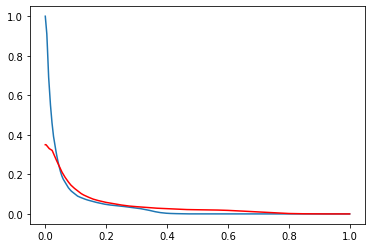

In [67]:
plt.plot(x,f)
plt.plot(x,g,color='r')

### Full calculation

In [121]:
for ivar,var in enumerate(['QV','T','T200','T150','LHF']):
    print('var=',var,end='\n')
    JS0[var] = {}; Hel[var] = {};
    if var=='QV': key_array = ['QV','RH','QfromQsat']; edg = edgQ; his = hisQ;
    elif var=='T': key_array = ['T','BMSE','TfromNS']; edg = edgT; his = hisT;
    #elif var=='T200': edg = edgT200; his = hisT200;
    elif var=='T150': edg = edgT150; his = hisT150;
    elif var=='LHF': key_array = ['LHF','LHF_nsQ','LHF_nsDELQ']; edg = edgLHF; his  = hisLHF;
        
    for ikey,key in enumerate(key_array):
        print('key=',key,'                   ',end='\r')
        JS0[var][key] = {}; Hel[var][key] = {};
        
        for ipath,path in enumerate(path_array):
            
            if ipath<3: 
                f_cold = his[key][path_array[0]]
                x_cold = edg2bin(edg[key][path_array[0]])
            elif ipath<6:
                f_cold = his[key][path_array[3]]
                x_cold = edg2bin(edg[key][path_array[3]])
            else:
                f_cold = his[key][path_array[6]]
                x_cold = edg2bin(edg[key][path_array[6]])
            
            f_data = his[key][path]; x_data = edg2bin(edg[key][path])

            xf_norm,xg_norm,f_norm,g_norm = maxmin_norm(x_cold,x_data,f_cold,f_data)
            x = np.linspace(0,1,1000)

            f = np.interp(x=x,xp=xf_norm,fp=f_norm)
            g = np.interp(x=x,xp=xg_norm,fp=g_norm)

            Hel[var][key][path] = Hellinger(x,f,g)
            JS0[var][key][path] = JS(x,f,g,eps=1e-4)

var= QV
var= T
var= T200
var= T150
var= LHF


/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/DFS-L/DATA/pritchard/tbeucler/Miniconda3_2021_04_12/miniconda3/envs/Griffin_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [122]:
JS0

{'QV': {'QV': {'2021_03_18_O3_TRAIN_M4K_shuffle.nc': 0.0,
   '2021_01_24_O3_TRAIN_shuffle.nc': 0.10053476613861903,
   '2021_03_18_O3_TRAIN_P4K_shuffle.nc': 0.14106358627913645,
   '2021_04_18_RG_TRAIN_M4K_shuffle.nc': 0.0,
   '2021_06_03_RG_TRAIN_shuffle.nc': 0.09196493476027953,
   '2021_04_18_RG_TRAIN_P4K_shuffle.nc': 0.1369547987279303,
   '1': 0.0,
   '2': 0.09960100175805539,
   '3': 0.5114127734566354},
  'RH': {'2021_03_18_O3_TRAIN_M4K_shuffle.nc': 0.0,
   '2021_01_24_O3_TRAIN_shuffle.nc': 0.03388749466183367,
   '2021_03_18_O3_TRAIN_P4K_shuffle.nc': 0.07724296169031303,
   '2021_04_18_RG_TRAIN_M4K_shuffle.nc': 0.0,
   '2021_06_03_RG_TRAIN_shuffle.nc': 0.023559521186652166,
   '2021_04_18_RG_TRAIN_P4K_shuffle.nc': 0.0398982252395975,
   '1': 0.0,
   '2': 0.04170646335751315,
   '3': 0.788874706473706},
  'QfromQsat': {'2021_03_18_O3_TRAIN_M4K_shuffle.nc': 0.0,
   '2021_01_24_O3_TRAIN_shuffle.nc': 0.07953828567655587,
   '2021_03_18_O3_TRAIN_P4K_shuffle.nc': 0.09075040733608686,

## Table code in latex

In [129]:
TABLEname = 'Hellinger'
if TABLEname=='JS': Name = 'Jensen-Shannon'
elif TABLEname=='Hellinger': Name = 'Hellinger'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
path = path_TXT+TABLEname+".txt"
VAR = ['QV','T','T150','LHF']
topline = "Input & SPCAM3 & SPCAM5 & SAM\\tabularnewline\n"
caption = Name+" distance (in $\\%$) away from the (-4K) simulation"+\
" for the PDFs of $\\left(q_{600\\mathrm{hPa}},T_{850\\mathrm{hPa}},T_{150\\mathrm{hPa}},\\mathrm{LHF}\\right)$"+\
" and their rescalings: (+0K) distance in gray and (+4K) distance in red." 

In [130]:
if TABLEname=='JS': S = JS0
elif TABLEname=='Hellinger': S = Hel

In [131]:
f= open(path,"w+")
f.write("\\begin{table}\n")
f.write("\\begin{centering}\n")
f.write("\\begin{tabular}{c|c|c|c}\n")
f.write(topline)
f.write("\\hline\n")
for ivar,var in enumerate(VAR):
    f.write("\\hline\n")
    if var=='QV': 
        key_array = ['QV','QfromQsat','RH']; 
        tex_array = ['$q_{600\\mathrm{hPa}}$','$q_{\\mathrm{deficit,}600\\mathrm{hPa}}$',
                     '$\mathrm{RH}_{600\\mathrm{hPa}}$']
    elif var=='T': 
        key_array = ['T','TfromNS','BMSE'];
        tex_array = ['$T_{850\\mathrm{hPa}}$',
                     '$T_{\\mathrm{from\\ NS},850\mathrm{hPa}}$',
                     '$B_{\\mathrm{plume},850\\mathrm{hPa}}$']
    elif var=='T150':
        tex_array = ['$T_{150\\mathrm{hPa}}$',
                     '$T_{\\mathrm{from\\ NS},150\\mathrm{hPa}}$',
                     '$B_{\\mathrm{plume},150\\mathrm{hPa}}$']
    elif var=='LHF': 
        key_array = ['LHF','LHF_nsQ','LHF_nsDELQ'];
        tex_array = ['$\\mathrm{LHF}$','$\\mathrm{LHF}_{q}$',
                     '$\\mathrm{LHF}_{\\Delta q}$']
    for ikey,key in enumerate(key_array):
        f.write(tex_array[ikey]+" & ")
        f.write("\\textcolor{gray}{")
        f.write("%2.1f"%(100*S[var][key][path_array[1]]))
        f.write("}, \\textcolor{red}{")
        f.write("%2.1f"%(100*S[var][key][path_array[2]]))
        f.write("} & \\textcolor{gray}{")
        f.write("%2.1f"%(100*S[var][key][path_array[4]]))
        f.write("}, \\textcolor{red}{")
        f.write("%2.1f"%(100*S[var][key][path_array[5]]))
        f.write("} & \\textcolor{gray}{")
        if var!='LHF':
            f.write("%2.1f"%(100*S[var][key][path_array[7]]))
        f.write("} \\tabularnewline")
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}{\\small \\par}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\label{tab:PDF}\n")
f.write("\\end{table}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table Hellinger printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/Hellinger.txt


# Table 3: MSE of different MLRs/NNs

Inspired from [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/073_CI_Results_Figure.ipynb]

## Load data

In [69]:
path_PKL = '/export/nfs0home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
epoch = np.arange(1,21)

### Trained on ref climate

In [70]:
path_MLR_BF = path_PKL + 'PKL_DATA2021_04_26_MLR_hist.pkl'
hf = open(path_MLR_BF,'rb')
hist_MLR_BF = pickle.load(hf)
hist_MLR_BF = hist_MLR_BF['hist']

In [71]:
path_NN_BF1 = path_PKL + 'PKL_DATA2021_04_26_NN_hist.pkl'
path_NN_BF2 = path_PKL + 'PKL_DATA2021_05_04_NN_hist.pkl'

hf = open(path_NN_BF1,'rb')
hist_NN_BF1 = pickle.load(hf)
hist_NN_BF1 = hist_NN_BF1['hist']

hf = open(path_NN_BF2,'rb')
hist_NN_BF2 = pickle.load(hf)
hist_NN_BF2 = hist_NN_BF2['hist']

In [73]:
hist_NN_BF = {}
for ikey,key in enumerate(hist_NN_BF1.keys()):
    hist_NN_BF[key] = 0.5*(np.array(hist_NN_BF1[key])+np.array(hist_NN_BF2[key]))

In [74]:
path_MLR_BMSE = path_PKL + 'PKL_DATA2021_06_17_MLR_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_BMSE,'rb')
hist_MLR_BMSE = pickle.load(hf)
hist_MLR_BMSE = hist_MLR_BMSE['hist']

In [75]:
path_MLR_TfromNS = path_PKL + 'PKL_DATA2021_04_26_MLR_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_TfromNS,'rb')
hist_MLR_TfromNS = pickle.load(hf)
hist_MLR_TfromNS = hist_MLR_TfromNS['hist']

In [76]:
path_NN_TfromNS = path_PKL + 'PKL_DATA2021_04_26_NN_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_TfromNS,'rb')
hist_NN_TfromNS = pickle.load(hf)
hist_NN_TfromNS = hist_NN_TfromNS['hist']

In [77]:
path_NN_BMSE = path_PKL + 'PKL_DATA2021_06_17_NN_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_BMSE,'rb')
hist_NN_BMSE = pickle.load(hf)
hist_NN_BMSE = hist_NN_BMSE['hist']

### Warm to cold

In [79]:
path_MLR_BF_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_MLR_hist.pkl'
hf = open(path_MLR_BF_W2C,'rb')
hist_MLR_BF_W2C = pickle.load(hf)
hist_MLR_BF_W2C = hist_MLR_BF_W2C['hist']

In [80]:
path_NN_BF_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_NN_hist.pkl'
hf = open(path_NN_BF_W2C,'rb')
hist_NN_BF_W2C = pickle.load(hf)
hist_NN_BF_W2C = hist_NN_BF_W2C['hist']

In [81]:
path_MLR_BMSE_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_MLR_RH_BCONS_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_BMSE_W2C,'rb')
hist_MLR_BMSE_W2C = pickle.load(hf)
hist_MLR_BMSE_W2C = hist_MLR_BMSE_W2C['hist']

In [82]:
path_NN_BMSE_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_NN_RH_BCONS_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_BMSE_W2C,'rb')
hist_NN_BMSE_W2C = pickle.load(hf)
hist_NN_BMSE_W2C = hist_NN_BMSE_W2C['hist']

In [83]:
path_MLR_TfromNS_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_MLR_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_TfromNS_W2C,'rb')
hist_MLR_TfromNS_W2C = pickle.load(hf)
hist_MLR_TfromNS_W2C = hist_MLR_TfromNS_W2C['hist']

In [84]:
path_NN_TfromNS_W2C = path_PKL + 'PKL_DATA2021_04_27_W2C_NN_RH_TfromNS_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_TfromNS_W2C,'rb')
hist_NN_TfromNS_W2C = pickle.load(hf)
hist_NN_TfromNS_W2C = hist_NN_TfromNS_W2C['hist']

### RG to aquaplanet

In [85]:
path_MLR_BF_RG2AQ = path_PKL + 'PKL_DATA2021_06_03_RG2AQ_MLR_hist.pkl'
hf = open(path_MLR_BF_RG2AQ,'rb')
hist_MLR_BF_RG2AQ = pickle.load(hf)
hist_MLR_BF_RG2AQ = hist_MLR_BF_RG2AQ['hist']

In [86]:
path_NN_BF_RG2AQ = path_PKL + 'PKL_DATA2021_06_03_RG2AQ_NN_hist.pkl'
hf = open(path_NN_BF_RG2AQ,'rb')
hist_NN_BF_RG2AQ = pickle.load(hf)
hist_NN_BF_RG2AQ = hist_NN_BF_RG2AQ['hist']

In [87]:
path_MLR_BMSE_RG2AQ = path_PKL + 'PKL_DATA2021_06_17_RG2AQ_MLR_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_MLR_BMSE_RG2AQ,'rb')
hist_MLR_BMSE_RG2AQ = pickle.load(hf)
hist_MLR_BMSE_RG2AQ = hist_MLR_BMSE_RG2AQ['hist']

In [88]:
path_NN_BMSE_RG2AQ = path_PKL + 'PKL_DATA2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ_hist.pkl'
hf = open(path_NN_BMSE_RG2AQ,'rb')
hist_NN_BMSE_RG2AQ = pickle.load(hf)
hist_NN_BMSE_RG2AQ = hist_NN_BMSE_RG2AQ['hist']

### Batch normalization & dropout

Climate-invariant

In [89]:
path_CI_DPBN = path_PKL+'PKL_DATA2021_08_03_NN_RH_BMSE_LHF_nsDELQ_Dropout30_BNL1_hist.pkl'
hf = open(path_CI_DPBN,'rb')
hist_CI_DPBN = pickle.load(hf)
hist_CI_DPBN = hist_CI_DPBN['hist']

In [90]:
path_CI_DPBN_W2C = path_PKL+'PKL_DATA2021_08_05_W2C_NN_RH_BMSE_LHF_nsDELQ_BNL1_Dropout30_hist.pkl'
hf = open(path_CI_DPBN_W2C,'rb')
hist_CI_DPBN_W2C = pickle.load(hf)
hist_CI_DPBN_W2C = hist_CI_DPBN_W2C['hist']

In [91]:
path_CI_DPBN_RG2AQ = path_PKL+'PKL_DATA2021_08_07_RG2AQ_NN_RH_BMSE_LHF_nsDELQ_BNL1_Dropout30_hist.pkl'
hf = open(path_CI_DPBN_RG2AQ,'rb')
hist_CI_DPBN_RG2AQ = pickle.load(hf)
hist_CI_DPBN_RG2AQ = hist_CI_DPBN_RG2AQ['hist'] 

Brute-force

In [93]:
path_BF_DPBN = path_PKL+'PKL_DATA2021_08_08_NN_BNL1_Dropout30_hist.pkl'
hf = open(path_BF_DPBN,'rb')
hist_BF_DPBN = pickle.load(hf)
hist_BF_DPBN = hist_BF_DPBN['hist']

In [94]:
path_BF_DPBN_W2C = path_PKL+'PKL_DATA2021_08_08_W2C_NN_BNL1_DP30_hist.pkl'
hf = open(path_BF_DPBN_W2C,'rb')
hist_BF_DPBN_W2C = pickle.load(hf)
hist_BF_DPBN_W2C = hist_BF_DPBN_W2C['hist']

In [95]:
path_BF_DPBN_RG2AQ = path_PKL+'PKL_DATA2021_08_09_RG2AQ_NN_BNL1_DP30_hist.pkl'
hf = open(path_BF_DPBN_RG2AQ,'rb')
hist_BF_DPBN_RG2AQ = pickle.load(hf)
hist_BF_DPBN_RG2AQ = hist_BF_DPBN_RG2AQ['hist'] 

## Create Table structure

In [196]:
MSE_array = np.zeros((3,2,6,4)) # Training sets x Best/5best x Models x Test sets

In [205]:
for itraining in range(3):
    for imodel in range(6):
        for itest in range(4):
        
            if itraining==0:
                if imodel==0: h = hist_MLR_BF; k = ['loss', 'val_loss', 'trainP4K_loss', 'trainM4K_RG_loss']
                elif imodel==1: h = hist_MLR_BMSE;
                elif imodel==2: h = hist_NN_BF;
                elif imodel==3: h = hist_BF_DPBN;
                elif imodel==4: h = hist_NN_BMSE;
                elif imodel==5: h = hist_CI_DPBN;
            elif itraining==1:
                if imodel==0: h = hist_MLR_BF_W2C; k = ['loss', 'val_loss', 'trainM4K_loss', 'trainP4K_RG_loss']
                elif imodel==1: h = hist_MLR_BMSE_W2C;
                elif imodel==2: h = hist_NN_BF_W2C;
                elif imodel==3: h = hist_BF_DPBN_W2C;
                elif imodel==4: h = hist_NN_BMSE_W2C;
                elif imodel==5: h = hist_CI_DPBN_W2C;
            elif itraining==2:
                if imodel==0: h = hist_MLR_BF_RG2AQ; k = ['loss', 'val_loss', 'trainM4K_loss', 'trainP4K_RG_loss']
                elif imodel==1: h = hist_MLR_BMSE_RG2AQ;
                elif imodel==2: h = hist_NN_BF_RG2AQ;
                elif imodel==3: h = hist_BF_DPBN_RG2AQ;
                elif imodel==4: h = hist_NN_BMSE_RG2AQ;
                elif imodel==5: h = hist_CI_DPBN_RG2AQ;
                 
            sortI = np.argsort(h[k[itest]])
            MSE_array[itraining,0,imodel,itest] = h[k[itest]][sortI[0]]
            hav = 0
            for iav in range(5):
                hav += h[k[itest]][sortI[iav]]/5
            MSE_array[itraining,1,imodel,itest] = hav 

In [206]:
MSE_array

array([[[[ 287.11117402,  288.11598898,  758.90221729,  242.08142289],
         [ 293.76082433,  295.28024048,  670.7392851 ,  244.70504782],
         [ 171.50021224,  172.46501454, 2166.69840228, 1097.74414623],
         [ 222.2906224 ,  205.49047099, 3225.41949269,  258.34723369],
         [ 168.1828624 ,  168.83162262,  422.45767988,  297.14024651],
         [ 214.03646156,  198.08084332,  483.04392227,  223.74575334]],

        [[ 287.72552378,  288.70623946,  785.3445987 ,  264.57652311],
         [ 294.03108209,  295.49485597,  671.3164503 ,  264.97253692],
         [ 172.09604856,  173.02085487, 2242.22209759, 1117.05410698],
         [ 222.48878954,  206.02322339, 3509.21137195,  318.13514165],
         [ 168.57171761,  169.24722777,  424.73102696,  315.60475745],
         [ 214.12770263,  198.47536021,  486.51962509,  226.91668654]]],


       [[[ 642.3658514 ,  643.36672895,  327.52253143,  506.71041051],
         [ 653.3779052 ,  653.34683373,  315.23279671,  515.36801732],


## Table code in latex

In [245]:
TABLEname = 'CI_Paper_Results'
path_TXT = '/export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/'
path = path_TXT+TABLEname+".txt"

topline1 = " & & Training Set & \\textbf{Validation Set} & Training Set & Training Set\\tabularnewline\n"
topline2 = "Trained & Model & Same temperature & Same temperature & \\textbf{Different temperature} & Same temperature\\tabularnewline\n"
topline3 = "on & & Same geography & Same geography & Same geography & \\textbf{Different geography}\\tabularnewline\n"

caption = "Mean-Squared Error (MSE, in units W$^{2}$ m$^{-4}$) of six models trained in three simulations (first column)"+\
" and evaluated over the training or validation set of the same and two other simulations (last four columns)."+\
" The models (second column) are brute-force (BF) or climate-invariant (CI), multiple linear regressions (MLR) "+\
"or neural nets (NN), and sometimes include dropout layers preceded by a batch normalization layer (DN)."+\
" The models are trained for 20 epochs and we give the MSE corresponding to the epoch of minimal validation loss"+\
" followed by the MSE averaged over the 5 epochs with lowest validation losses (in parentheses)."

COLOR = ['black','purple','black','teal','purple','teal']
MODEL = [[" & MLR BF",
          "\\textcolor{blue}{Cold} & \\textcolor{purple}{MLR CI}",
          "\\textcolor{blue}{Aquaplanet} & NN BF",
          "\\textcolor{blue}{(-4K)} & \\textcolor{teal}{NN BF+DN}",
          "SPCAM3 & \\textcolor{purple}{NN CI}",
          " & \\textcolor{teal}{NN CI+DN}"],
         [" & MLR BF",
          "\\textcolor{red}{Warm} & \\textcolor{purple}{MLR CI}",
          "\\textcolor{red}{Aquaplanet} & NN BF",
          "\\textcolor{red}{(+4K)} & \\textcolor{teal}{NN BF+DN}",
          "SPCAM3 & \\textcolor{purple}{NN CI}",
          " & \\textcolor{teal}{NN CI+DN}"],
         [" & MLR BF",
          "\\textcolor{green}{Cold} & \\textcolor{purple}{MLR CI}",
          "\\textcolor{green}{Earth-like} & NN BF",
          "\\textcolor{green}{(-4K)} & \\textcolor{teal}{NN BF+DN}",
          "SPCAM5 & \\textcolor{purple}{NN CI}",
          " & \\textcolor{teal}{NN CI+DN}"]]

In [246]:
f= open(path,"w+")
f.write("\\begin{table*}\n")
f.write("\\begin{centering}\n")
f.write("\\begin{tabular}{c|c||c|c|c|c}\n")
f.write(topline1)
f.write(topline2)
f.write(topline3)
for itrain in range(3):
    f.write("\\hline\n")
    for imodel in range(6):
        f.write(MODEL[itrain][imodel])
        for itest in range(4):
            f.write(" & ")
            f.write("\\textcolor{"+COLOR[imodel]+"}{")
            f.write("%3.0f"%MSE_array[itrain,0,imodel,itest]+" ")
            f.write("("+"%3.0f"%MSE_array[itrain,1,imodel,itest]+") ")
            f.write("}")
        f.write("\\tabularnewline\n")
f.write("\\end{tabular}\n")
f.write("\\par\\end{centering}\n")
f.write("\n")
f.write("\\caption{")
f.write(caption)
f.write("}\n")
f.write("\\label{tab:Results}\n")
f.write("\\end{table*}\n")
f.close()
print('Table',TABLEname,'printed to',path)

Table CI_Paper_Results printed to /export/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog/TXT_DATA/CI_Paper_Results.txt
